In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('./Assets/data_.csv', index_col = 'Date')
data.head()

,High,Low,Open,Close,Volume,Adj Close,pct_change,log_change,volume_change,volume_log_change,...,NASDQ,dealer_buy,dealer_sell,dealer_dif,investment_buy,investment_sell,investment_dif,foreign_buy,foreign_sell,foreign_dif
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,59.2,58.2,59.0,58.4,53679000.0,38.37,-0.003413,-0.003419,0.173209,0.159743,...,2147.87,3161497580,2968407011,193090569,3102476560,1648311871,1454164689,1.551380e+10,2.549564e+10,-9981838210
2010-02-22,60.5,59.0,60.5,59.0,47519000.0,38.76,0.010274,0.010222,-0.114756,-0.121892,...,2242.03,3133892869,2444166818,689726051,2130761100,1359109401,771651699,2.846749e+10,2.503619e+10,3431302085
2010-02-23,59.9,59.1,59.6,59.8,50343000.0,39.29,0.013559,0.013468,0.059429,0.057730,...,2213.44,2000150200,2287498353,-287348153,2263043520,2650742656,-387699136,2.422218e+10,2.360860e+10,613580581
2010-02-24,59.2,58.4,59.2,58.5,54884000.0,38.43,-0.021739,-0.021979,0.090201,0.086362,...,2235.90,2043898760,1998239251,45659509,2258613250,1775532693,483080557,2.027639e+10,2.546846e+10,-5192069643
2010-02-25,58.9,57.9,58.5,58.2,55655000.0,38.24,-0.005128,-0.005141,0.014048,0.013950,...,2234.22,1728179056,3572176638,-1843997582,1801497370,2286138110,-484640740,2.259238e+10,3.143820e+10,-8845826819


In [3]:
data['y'] = data['log_change']
from Tools.train_test_split import train_test_split

train_x, train_y, test_x, test_y, x_scaler, y_scaler = train_test_split(data, 60, 20, 0.8)

train_x: (2324, 60) train_y: (2324, 1)
test_x: (602, 60) test_y: (602, 1)


[1/200] Loss: 657.2321481704712
[2/200] Loss: 594.4712476730347
[3/200] Loss: 529.0437841415405
[4/200] Loss: 464.7979311943054
[5/200] Loss: 410.13756251335144
[6/200] Loss: 364.49530839920044
[7/200] Loss: 324.24327087402344
[8/200] Loss: 289.58951807022095
[9/200] Loss: 260.2116734981537
[10/200] Loss: 237.86848163604736
[11/200] Loss: 221.0573606491089
[12/200] Loss: 204.44060063362122
[13/200] Loss: 182.23458909988403
[14/200] Loss: 155.82492089271545
[15/200] Loss: 130.82504796981812
[16/200] Loss: 109.30482792854309
[17/200] Loss: 90.99200105667114
[18/200] Loss: 79.43604683876038
[19/200] Loss: 74.97284078598022
[20/200] Loss: 73.9209213256836
[21/200] Loss: 72.11770725250244
[22/200] Loss: 66.21221351623535
[23/200] Loss: 58.37003242969513
[24/200] Loss: 53.109092473983765
[25/200] Loss: 52.0129109621048
[26/200] Loss: 52.84001934528351
[27/200] Loss: 53.090812623500824
[28/200] Loss: 51.80500543117523
[29/200] Loss: 49.523900389671326
[30/200] Loss: 47.39067602157593
[31/200]

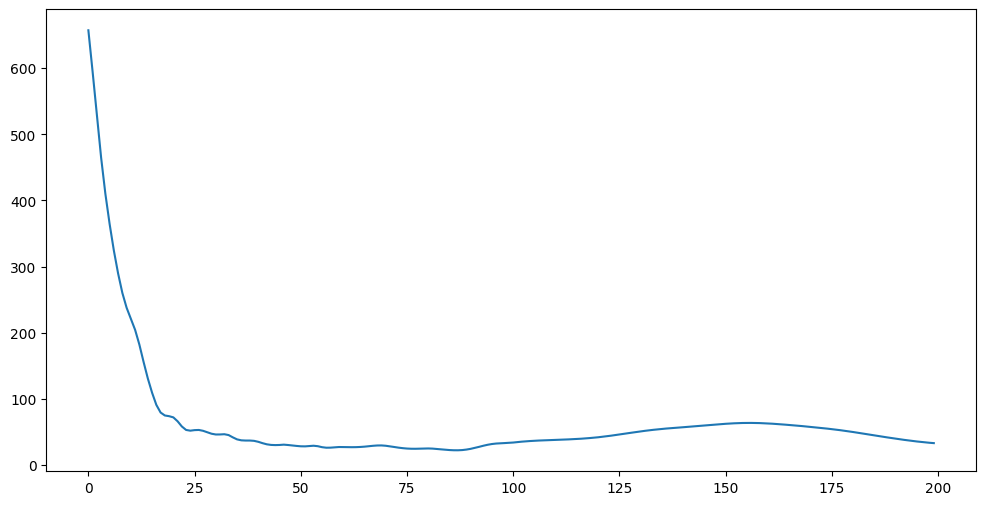

In [4]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()), batch_size = 128, shuffle = True)

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

from Models.VAE import VAE

model_vae = VAE([60, 45, 30, 20], 20)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_vae.parameters(), lr = learning_rate)
epochs = 200
hist = np.zeros(epochs)

for epoch in range(epochs):
    loss_ = []
    for idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        output, z, mu, logVar = model_vae(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, epochs), sum(loss_))
plt.figure(figsize=(12, 6))
plt.plot(hist)


In [5]:
# In this section we use vae to transform the feature, and prepare the data
# for GAN. The discriminator will use a true data in sequence length of 7.
from Tools.gan_make_data import gan_make_data

model_vae.eval()

output, latent_train_x, mu, logVar = model_vae(torch.from_numpy(train_x).to(device).float()) # 20 feature




gan_train_x, gan_train_y, y_label = gan_make_data(20, latent_train_x.detach().cpu().numpy(), train_y)
gan_train_loader = DataLoader(TensorDataset(torch.from_numpy(gan_train_x).float(), torch.from_numpy(gan_train_y).float()), batch_size = 128, shuffle = True)

output, latent_test_x, mu, logVar = model_vae(torch.from_numpy(test_x).to(device).float()) 
gan_test_x, gan_test_y, y_label_test = gan_make_data(20, latent_test_x.detach().cpu().numpy(), test_y)
gan_test_loader = DataLoader(TensorDataset(torch.from_numpy(gan_test_x).float(), torch.from_numpy(y_label_test).float()), batch_size = 128, shuffle = True)

[1/200] LossD: 24.892586827278137 LossG:12.783531785011292
[2/200] LossD: 24.697062492370605 LossG:12.705654501914978
[3/200] LossD: 24.464964747428894 LossG:12.77728933095932
[4/200] LossD: 24.130770921707153 LossG:12.927509188652039
[5/200] LossD: 23.639599084854126 LossG:13.119941651821136
[6/200] LossD: 22.863186478614807 LossG:13.481364727020264
[7/200] LossD: 21.714981198310852 LossG:14.12811690568924
[8/200] LossD: 20.277187705039978 LossG:14.957346081733704
[9/200] LossD: 19.8511221408844 LossG:15.244979560375214
[10/200] LossD: 21.10084640979767 LossG:15.682390868663788
[11/200] LossD: 23.66753852367401 LossG:14.347798526287079
[12/200] LossD: 26.432559490203857 LossG:12.939963817596436
[13/200] LossD: 27.253146767616272 LossG:12.389512836933136
[14/200] LossD: 26.498255729675293 LossG:12.820691525936127
[15/200] LossD: 25.488279819488525 LossG:13.39357191324234
[16/200] LossD: 24.76847529411316 LossG:13.484695672988892
[17/200] LossD: 24.466702938079834 LossG:12.9170870184898

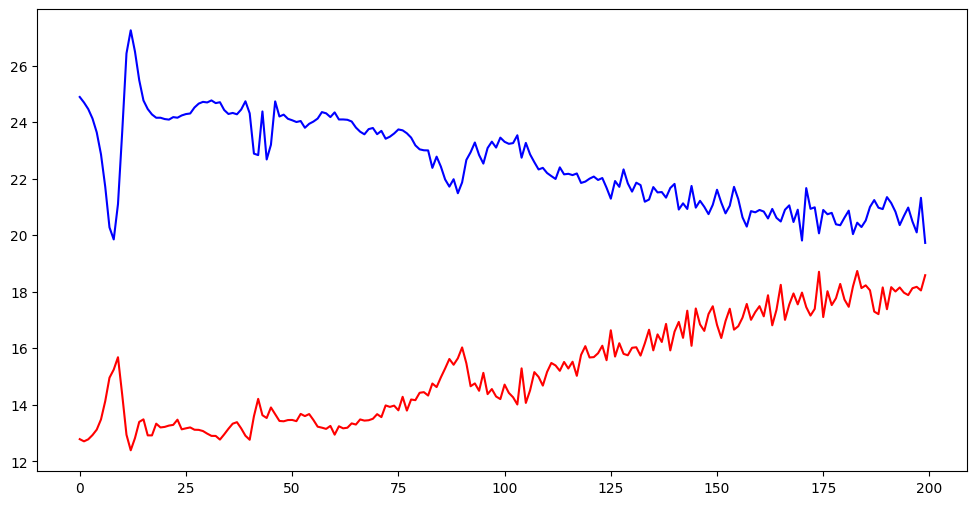

In [6]:
from Models.GAN import generator, discriminator

batch_size = 128
optimizer_betas = (0.9, 0.999)
epochs = 200

gen = generator(20, 100, 3, 1, 0.2).to(device)
dis = discriminator([7, 32, 64, 128], batch_size).to(device)

learning_rate = 0.00005
criterion = nn.BCELoss()
optimizer_generator = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=optimizer_betas)
optimizer_discriminator = torch.optim.Adam(dis.parameters(), lr=learning_rate, betas=optimizer_betas)
loss_g = np.zeros(epochs)
loss_d = np.zeros(epochs)

for epoch in range(epochs):
    lossG_ = []
    lossD_ = []
    for idx, (x, y) in enumerate(gan_train_loader):
        x = x.to(device)
        y = y.to(device)
        dis_real_output = dis(y)
        real_labels = torch.ones_like(dis_real_output)
        lossD_real = criterion(dis_real_output, real_labels)

        fake_data = gen(x)
        fake_data = torch.cat([y[:, :6, :], fake_data.reshape(batch_size, 1, 1)], axis = 1)
        dis_fake_output = dis(fake_data)
        fake_labels = torch.zeros_like(real_labels)
        lossD_fake = criterion(dis_fake_output, fake_labels)
        
        lossD = (lossD_real + lossD_fake)

        dis.zero_grad()
        lossD.backward(retain_graph=True)
        optimizer_discriminator.step()
        lossD_.append(lossD.item())

        output_fake = dis(fake_data)
        lossG = criterion(output_fake, real_labels)
        gen.zero_grad()
        lossG.backward()
        optimizer_generator.step()
        lossG_.append(lossG.item())        
    loss_g[epoch] = sum(lossG_) 
    loss_d[epoch] = sum(lossD_)
    print(f'[{epoch+1}/{epochs}] LossD: {sum(lossD_)} LossG:{sum(lossG_)}')

plt.figure(figsize=(12, 6))
plt.plot(loss_g, color = 'red', label = 'lossG')
plt.plot(loss_d, color = 'blue', label = 'lossD')


In [7]:
gan_train_loader = DataLoader(TensorDataset(torch.from_numpy(gan_train_x).float(), torch.from_numpy(gan_train_y).float()), batch_size = 128, shuffle = False)
gan_test_loader = DataLoader(TensorDataset(torch.from_numpy(gan_test_x).float(), torch.from_numpy(y_label_test).float()), batch_size = 128, shuffle = False)

gen.eval()
y_predict = []
for idx, (x, y) in enumerate(gan_train_loader):
    x = x.to(device)
    y = y.to(device)

    predict_y = gen(x)
    y_predict.append(predict_y.detach().numpy())

y_predict_test = []
for idx, (x, y) in enumerate(gan_test_loader):
    x = x.to(device)
    y = y.to(device)

    predict_y_test = gen(x)
    y_predict_test.append(predict_y_test.detach().numpy())        

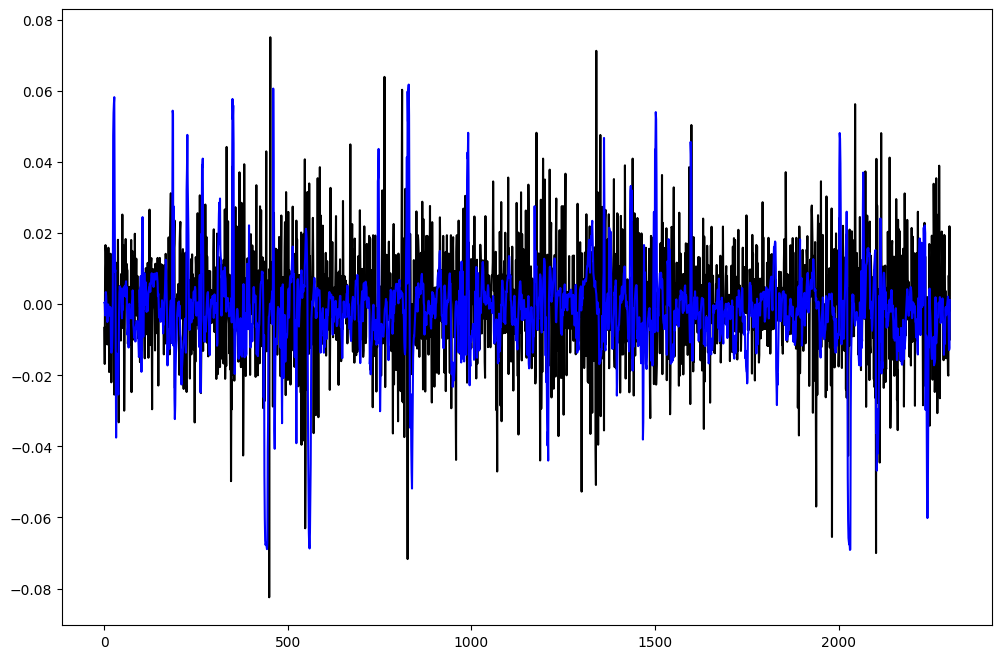

In [8]:
# prediciting training data

predict_price = []
for i in y_predict:
    for j in i:
        predict_price.append(j)

predict_price = np.array(predict_price)
predict_price = y_scaler.inverse_transform(predict_price)
actual_y = y_scaler.inverse_transform(y_label.reshape(-1, 1))

plt.figure(figsize=(12, 8))
plt.plot(actual_y, color = 'black')
plt.plot(predict_price, color = 'blue')

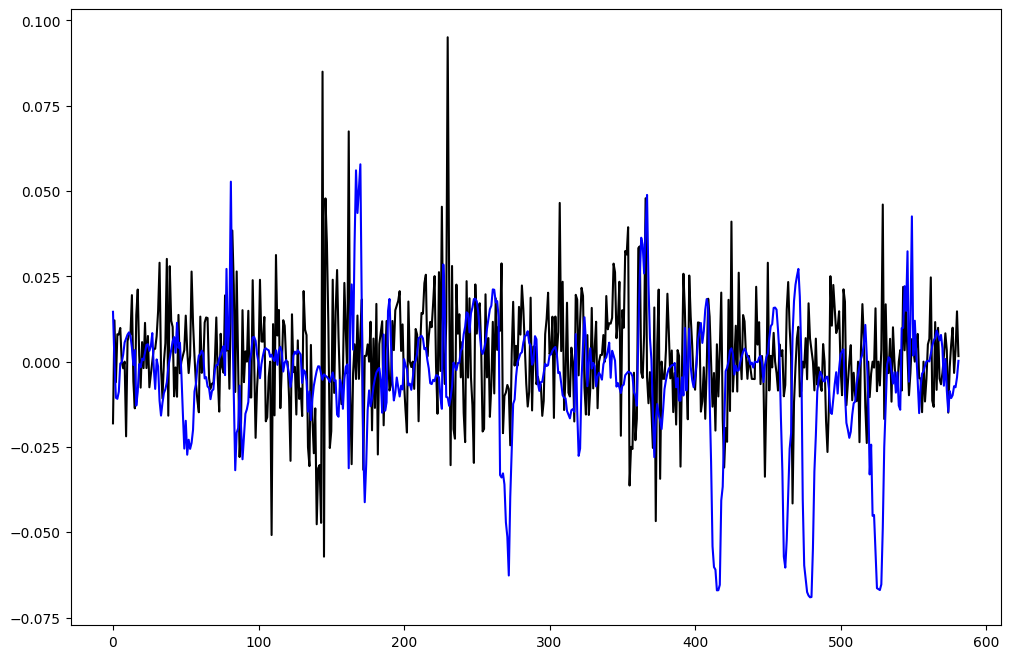

In [9]:
# predicting testing data

predict_price = []
for i in y_predict_test:
    for j in i:
        predict_price.append(j)

predict_price = np.array(predict_price)
predict_price = y_scaler.inverse_transform(predict_price)
actual_y = y_scaler.inverse_transform(y_label_test.reshape(-1, 1))

plt.figure(figsize=(12, 8))
plt.plot(actual_y, color = 'black')
plt.plot(predict_price, color = 'blue')

In [10]:
vae_gan = []
for i in range(actual_y.shape[0]):
    if actual_y[i]* predict_price[i] > 0:
        vae_gan.append(1)
    else:
        vae_gan.append(0)

print(f'VAE + GAN accuracy: {sum(vae_gan)/ len(vae_gan)}')


VAE + GAN accuracy: 0.46048109965635736
